In [1]:
import time
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils
import select_copula
from select_copula import conf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
animal = 'ST260'
dayN = 1
day_name = 'Day{}'.format(dayN)
path = '/home/nina/VRData/Processing/pkls'

n1 = 1
n2 = 8

X,Y = utils.load_experimental_data(path, animal, day_name, n1, n2)
device = torch.device("cpu")
# train_x = torch.tensor(X).float().to(device=device)
# train_y = torch.tensor(Y).float().to(device=device)
exp_pref = '{}_{}'.format(animal,day_name)

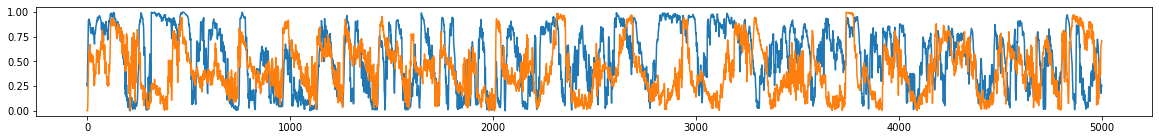

In [8]:
plt.figure(figsize=(20,2))
plt.plot(Y[:5000,])

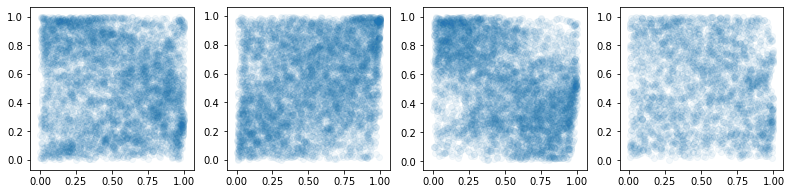

In [9]:
fig, ax = plt.subplots(1,4,figsize=(13.5,3))
ax[0].scatter(*Y[X<6/16].T,alpha=0.05)
ax[1].scatter(*Y[(X>=6/16) & (X<12/16)].T,alpha=0.05)
ax[2].scatter(*Y[(X>=12/16) & (X<14/16)].T,alpha=0.05)
ax[3].scatter(*Y[(X>=14/16) & (X<1)].T,alpha=0.05)

In [10]:
X.shape

(21471,)

In [ ]:
%time (likelihoods, waic) = select_copula.select_with_heuristics(X, Y, device, exp_pref, '../outputs', '0', '1')

In [ ]:
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device)

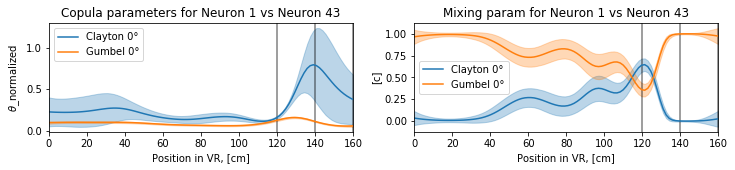

In [7]:
assert waic>=conf.waic_threshold*X.shape[0]

# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [22]:
import logging
import sys
log = logging.getLogger()
#log.setLevel(logging.DEBUG)
#log.addHandler(logging.StreamHandler(sys.stdout))

#%time (model, waic) = select_copula.select_copula_model(X,Y,torch.device("cuda:1"),exp_pref,'./imgs',n1,n2)
%time (waic, model_claytons) = bvcopula.infer(conf.clayton_likelihoods,train_x,train_y,device=device)

CPU times: user 2min 5s, sys: 1min 1s, total: 3min 6s
Wall time: 3min 6s


tensor(6914.4565, device='cuda:1')


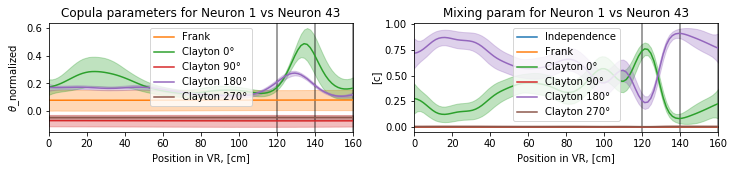

In [23]:
assert waic>=conf.waic_threshold*X.shape[0]

print(waic)

# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model_claytons,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [24]:
%time (waic_gumbels, model_gumbels) = bvcopula.infer(conf.gumbel_likelihoods,train_x,train_y,device=device)

CPU times: user 2min 2s, sys: 59.6 s, total: 3min 1s
Wall time: 3min 1s


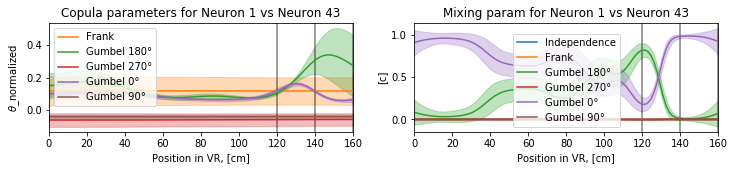

In [25]:
assert waic_gumbels>=conf.waic_threshold*X.shape[0]

# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model_gumbels,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [27]:
which_claytons = select_copula.important_copulas(model_claytons,device)
print(which_claytons, waic)
which_gumbels = select_copula.important_copulas(model_gumbels,device)
print(which_gumbels, waic_gumbels)
# likelihoods_list = select_copula.models_to_try(which)

tensor([False, False,  True, False,  True, False], device='cuda:1') tensor(6914.4565, device='cuda:1')
tensor([False, False,  True, False,  True, False], device='cuda:1') tensor(7046.0410, device='cuda:1')


In [13]:
which_claytons =torch.tensor([False, True,  True, False,  True, False], device='cuda:1')
which_gumbels =torch.tensor([False, False,  True, True,  True, False], device='cuda:1')
which_claytons+which_gumbels

tensor([False,  True,  True,  True,  True, False], device='cuda:1')

In [28]:
likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='0°'),bvcopula.GumbelCopula_Likelihood(rotation='0°'),]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device)
which = select_copula.important_copulas(model,device)
print(which, waic)

CPU times: user 1min 14s, sys: 17.6 s, total: 1min 31s
Wall time: 1min 31s
tensor([True, True], device='cuda:1') tensor(7060.1284, device='cuda:1')


In [29]:
likelihoods = [bvcopula.ClaytonCopula_Likelihood(rotation='0°'),bvcopula.ClaytonCopula_Likelihood(rotation='180°'),]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device)
which = select_copula.important_copulas(model,device)
print(which, waic)

CPU times: user 1min 10s, sys: 16.5 s, total: 1min 26s
Wall time: 1min 26s
tensor([True, True], device='cuda:1') tensor(6914.6523, device='cuda:1')


In [114]:
len(likelihoods_list)

6

In [11]:
which = select_copula.important_copulas(model, device)
if torch.any(which==False):
    print('Hi')

Hi


tensor(6093.8228, device='cuda:1') tensor([True, True, True], device='cuda:1')
tensor(6182.6914, device='cuda:1') tensor([True, True, True], device='cuda:1')
tensor(6193.9019, device='cuda:1') tensor([True, True, True, True], device='cuda:1')
tensor(6153.0601, device='cuda:1') tensor([True, True, True, True], device='cuda:1')
tensor(6095.0908, device='cuda:1') tensor([False,  True,  True,  True], device='cuda:1')
tensor(6198.4019, device='cuda:1') tensor([True, True, True, True], device='cuda:1')


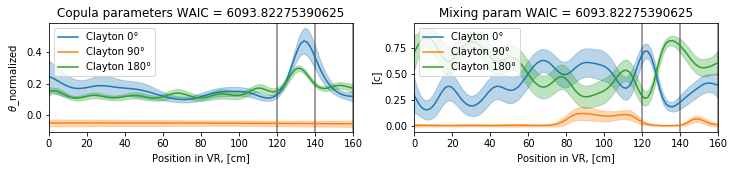

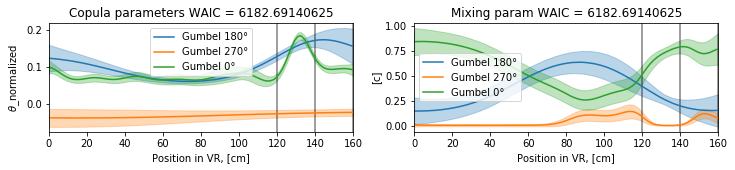

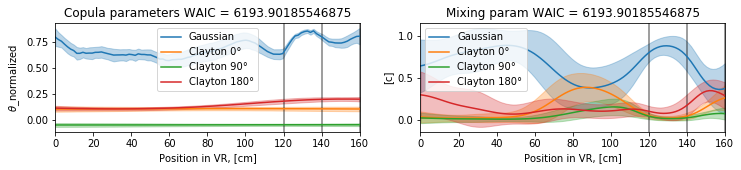

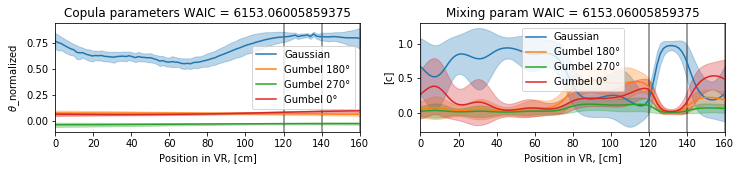

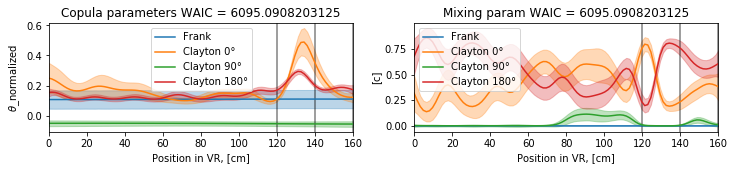

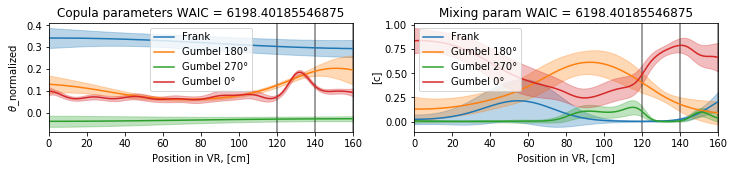

In [115]:
# define test set (optionally on GPU)
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

waics = np.zeros(len(likelihoods_list))
importance = np.zeros(len(likelihoods_list),dtype=np.dtype(object))
for i, likelihood in enumerate(likelihoods_list):
    (waic, model) = bvcopula.infer(likelihood,train_x,train_y,device=device)
    waics[i] = waic
    which = select_copula.important_copulas(model, device)
    importance[i] = which.cpu().numpy()
    print(waic, which)
    # visualize the result
    fig, ax = plt.subplots(1,2,figsize=(12, 2))

    for a in ax:
        a.axvline(120, color='black', alpha=0.5)
        a.axvline(140, color='black', alpha=0.5)
        a.axvline(160, color='black', alpha=0.5)  

    utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,title=f"WAIC = {waic}")

In [116]:
likelihoods_list0 = likelihoods_list.copy()
waics0 = waics.copy()
importance0 = importance.copy()

[autoreload of select_copula.heuristics failed: Traceback (most recent call last):
  File "/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/home/nina/.envs/GPyTorch_new/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/nina/.envs/GPyTorch_new/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/nina/CopulaGP/select_copula/heuristics.py", line 60, in <module>
    train_x = None, train_y = None):
NameError: name 'Tenso

In [117]:
import utils
while np.any(importance[np.argmax(waics)]!=True):
    idx = np.argmax(waics)
    idxs = torch.arange(0,len(importance[idx]))[importance[idx]]
    likelihood = [likelihoods_list[idx][i] for i in idxs]
    print(utils.get_copula_name_string(likelihood))
    (waic, model) = bvcopula.infer(likelihood,train_x,train_y,device=device)
    print(utils.get_copula_name_string(model.likelihood.likelihoods))
    print(f"{waics[idx]} -> {waic}")
    waics[idx] = waic
    which = select_copula.important_copulas(model, device)
    importance[idx] = which.cpu().numpy()
    likelihoods_list[idx] = likelihood
print(utils.get_copula_name_string(likelihoods_list[np.argmax(waics)]))

FrankGumbel180°Gumbel270°Gumbel0°


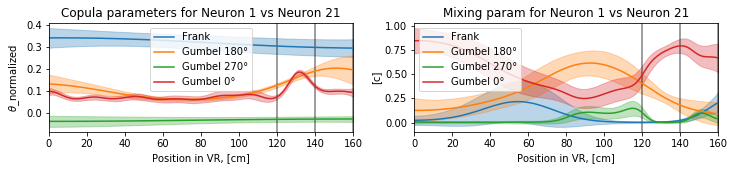

In [118]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))

name1 = f'Neuron {n1}'
name2 = f'Neuron {n2}'
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)  
    
utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,title='for {} vs {}'.format(name1,name2))

In [ ]:
# from GPUtil import showUtilization as gpu_usage
# gpu_usage()